In [43]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch, torch.nn as nn
from PIL import Image
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils import data
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torchvision
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from torchmetrics.detection import MeanAveragePrecision
import pickle

In [2]:
DISABLE_TQDM = False

In [3]:
def train_test_split(path):
    train_path = path + "train_images/"
    train_list = [os.path.join(train_path, img) for img in os.listdir(train_path)]
    random.shuffle(train_list)
    threshold = int(0.8 * len(train_list))
    valid_list = train_list[threshold:]
    train_list = train_list[:threshold]
    test_path = path + "test_images/"
    test_list = [os.path.join(test_path, img) for img in os.listdir(test_path)]
    return train_list, valid_list, test_list

In [4]:
def compute_annotation_map(annotations):
    annotation_map = {}
    for _, row in annotations.iterrows():
        boxes = annotation_map.get(row['image_id'], [])
        boxes.append((row['lesion_type'], [row['xmin'] if row['xmin']>=0 else -1,
                                           row['ymin'] if row['ymin']>=0 else -1,\
                                           row['xmax'] if row['xmax']>=0 else -1,\
                                           row['ymax'] if row['ymax']>=0 else -1\
                                           ]))
        annotation_map[row['image_id']] = boxes
    return annotation_map

In [5]:
def split_annotation_map(annotation_map, train, valid):
    train_ids = [image.split('/')[-1].split('.')[0] for image in train]
    valid_ids = [image.split('/')[-1].split('.')[0] for image in valid]
    return { image:annotation_map[image] for image in train_ids} , { image:annotation_map[image] for image in valid_ids}

In [6]:
class SpineObjectDetection(data.Dataset):
    
    def __init__(self, root_dir, annotaion_map,anomaly_map,image_id_map,transform=None):
        self.img_paths = root_dir
        self.img_paths.sort()
        self.image_ids = [image.split('/')[-1].split('.')[0] for image in self.img_paths]
        
        self.annotaion_map = annotaion_map
        self.anomaly_map = anomaly_map
        self.image_id_map = image_id_map
        self.transform = transform
        
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx])
        image_id = self.image_ids[idx]
        
        image_width = image.size[0]
        image_height = image.size[1]
        
        
        image = self.transform(image)
        image = torchvision.transforms.Resize(np.random.randint(640,800))(image)
        
        transformed_h = image.shape[1]
        transformed_w = image.shape[2]
        
        
        labels = []
        boxes = []
        
        for label, box in self.annotaion_map[image_id]:
            labels.append(self.anomaly_map[label])
            
            if box[0]==-1 and box[1]==-1:
                boxes.append([0,0,transformed_w,transformed_h])
            else:
                boxes.append([
                    (box[0]/image_width)*transformed_w,
                    (box[1]/image_height)*transformed_h,
                    (box[2]/image_width)*transformed_w,
                    (box[3]/image_height)*transformed_h
                    ])
            
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor(self.image_id_map[image_id])

        return image, target

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

def create_faster_rcnn_model(num_classes,trainable_backbone_layers=3):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,trainable_backbone_layers=trainable_backbone_layers,min_size=640,max_size=2699)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def show_tranformed_image(loader,number):
    images, targets = next(iter(loader))
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    for image,target in list(zip(images,targets))[:number]:
        result = draw_bounding_boxes((image*255).byte(), target['boxes'], width=5,colors=['white']*len(target['boxes']))
        show(result)
        
def save_object(path,file_name,obj):
    with open(os.path.join(path,file_name + ".pickle"), 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

def load_object(path,file_name):
    with open(os.path.join(path,file_name + ".pickle"), 'rb') as file:
        return pickle.load(file)

In [89]:
class SaveBestModel:
    def __init__(self, model_name, path="/"):
        self.best_valid_loss = float('inf')
        self.path = path
        self.model_name = model_name
        
    def update(self, model, current_valid_loss):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"Best validation loss: {self.best_valid_loss}")
            torch.save(model, os.path.join(self.path,self.model_name))
            print(f"Saved best model")
            
    def fetch(self):
        return torch.load(os.path.join(self.path,self.model_name))
    
class LossHistory:
    def __init__(self,path,file_name):
        self.loss = {
            'total_loss': [],
            'classifier_loss' : [],
            'box_reg_loss':[],
            'objectness_loss': [],
            'rpn_box_reg_loss':[]
        }
        self.file_name = file_name
        self.path = path
    
    def update(self,total_loss,classifier_loss,box_reg_loss,objectness_loss,rpn_box_reg_loss):
        self.loss['total_loss'].append(total_loss)
        self.loss['classifier_loss'].append(classifier_loss)
        self.loss['box_reg_loss'].append(box_reg_loss)
        self.loss['objectness_loss'].append(objectness_loss)
        self.loss['rpn_box_reg_loss'].append(objectness_loss)
        
    def save(self):
        save_object(self.path,self.file_name,self.loss)
    
    def load(self):
        self.loss = load_object(self.path,self.file_name)

In [73]:
def train_one_epoch(model,train_loader,optim):
    running_total_loss, running_loss_classifier, running_loss_box_reg, running_loss_objectness,running_loss_rpn_box_reg = 0,0,0,0,0
    for images, targets in tqdm(train_loader, disable=DISABLE_TQDM):
        images_device = list(image.to(device) for image in images)
        targets_device = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optim.zero_grad()
        model.train()
        with torch.set_grad_enabled(True):
            loss_dict = model.forward(images_device,targets_device)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()
            optim.step()

        running_total_loss += loss.item()
        running_loss_classifier +=loss_dict['loss_classifier'].item()
        running_loss_box_reg +=loss_dict['loss_box_reg'].item()
        running_loss_objectness +=loss_dict['loss_objectness'].item()
        running_loss_rpn_box_reg +=loss_dict['loss_rpn_box_reg'].item()


    epoch_total_loss = running_total_loss / len(train_loader)
    epoch_loss_classifier = running_loss_classifier / len(train_loader)
    epoch_loss_box_reg = running_loss_box_reg / len(train_loader)
    epoch_loss_objectness = running_loss_objectness / len(train_loader)
    epoch_loss_rpn_box_reg = running_loss_rpn_box_reg / len(train_loader)
    print("Train Loss: {:.6f}\t Train Loss Classifier: {:.6f}\t Train Loss Box Reg: {:.6f}\t Train Loss Objectness: {:.6f}\t Train Loss RPN box: {:.6f} "\
          .format(epoch_total_loss, epoch_loss_classifier,epoch_loss_box_reg,epoch_loss_objectness,epoch_loss_rpn_box_reg))
    return epoch_total_loss,epoch_loss_classifier,epoch_loss_box_reg,epoch_loss_objectness, epoch_loss_rpn_box_reg

def evaluate_loss(model,loader):
    running_total_loss, running_loss_classifier, running_loss_box_reg, running_loss_objectness,running_loss_rpn_box_reg = 0,0,0,0,0
    for images, targets in tqdm(loader, disable=DISABLE_TQDM):
        images_device = list(image.to(device) for image in images)
        targets_device = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model.train()
        with torch.set_grad_enabled(False):
            loss_dict = model.forward(images_device,targets_device)
            loss = sum(loss for loss in loss_dict.values())

        running_total_loss += loss.item()
        running_loss_classifier +=loss_dict['loss_classifier'].item()
        running_loss_box_reg +=loss_dict['loss_box_reg'].item()
        running_loss_objectness +=loss_dict['loss_objectness'].item()
        running_loss_rpn_box_reg +=loss_dict['loss_rpn_box_reg'].item()

    epoch_total_loss = running_total_loss / len(loader)
    epoch_loss_classifier = running_loss_classifier / len(loader)
    epoch_loss_box_reg = running_loss_box_reg / len(loader)
    epoch_loss_objectness = running_loss_objectness / len(loader)
    epoch_loss_rpn_box_reg = running_loss_rpn_box_reg / len(loader)
    print("Total Loss: {:.6f}\t Classifier Loss: {:.6f}\t Box Reg Loss: {:.6f}\t Objectness Loss: {:.6f}\t RPN box Loss: {:.6f} "\
          .format(epoch_total_loss, epoch_loss_classifier,epoch_loss_box_reg,epoch_loss_objectness,epoch_loss_rpn_box_reg))
    
    return epoch_total_loss,epoch_loss_classifier,epoch_loss_box_reg,epoch_loss_objectness, epoch_loss_rpn_box_reg

def evaluate_average_precision(model,loader):
    metric = MeanAveragePrecision(class_metrics=True)
    for images, targets in tqdm(loader, disable=DISABLE_TQDM):
        images_device = list(image.to(device) for image in images)
        targets_device = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model.eval()
        with torch.set_grad_enabled(False):
            preds = model.forward(images_device)
            metric.update(preds,targets)
    mAP =  metric.compute()
    print(mAP)
    return mAP

In [90]:
def train_model(model, best_model, train_loader,valid_loader, optim, path=".",evaluate_map_every=5):
    train_history = LossHistory(path, "train_history")
    valid_history = LossHistory(path, "valid_history")
    mAP_history = []
    for i in range(1, n_epochs+1):
        print(f"\nEpoch {i}:")
        print("-"*100)

        ## Training
        total_loss,classifier_loss,box_reg_loss,objectness_loss, rpn_box_reg_loss = train_one_epoch(model,train_loader,optim)
        train_history.update(total_loss,classifier_loss,box_reg_loss,objectness_loss, rpn_box_reg_loss)
        
        ## Validation
        total_loss,classifier_loss,box_reg_loss,objectness_loss, rpn_box_reg_loss = evaluate_loss(model,valid_loader)
        valid_history.update(total_loss,classifier_loss,box_reg_loss,objectness_loss, rpn_box_reg_loss)
        best_model.update(model,total_loss)
        
        ## Validation Eval mAP
        if i%evaluate_map_every ==0:
            mAP = evaluate_average_precision(model,valid_loader)
            mAP_history.append(mAP)
            
        train_history.save(),
        valid_history.save()
        save_object(path,"map_history", mAP_history)
    return best_model.fetch(),train_history,valid_history,mAP_history

In [75]:
path = '/scratch1/knarasim/physionet.org/files/vindr-spinexr/tiny_vindr/'
train_path = path + "train_images/"
test_path  = path + "test_images/"
annot_path = path + "annotations/"

anomaly_map = {
    'No finding': 0,
    'Disc space narrowing': 1,
    'Foraminal stenosis': 2,
    'Osteophytes': 3,
    'Spondylolysthesis': 4,
    'Surgical implant': 5,
    'Vertebral collapse': 6,   
    'Other lesions': 7,
 }

In [76]:
train, valid, test = train_test_split(path)

train_annotations = pd.read_csv(annot_path + "train.csv")
test_annotations = pd.read_csv(annot_path + "test.csv")

train_annotation_map = compute_annotation_map(train_annotations)
train_annotation_map, valid_annotation_map = split_annotation_map(train_annotation_map, train, valid)

test_annotation_map = compute_annotation_map(test_annotations)

In [77]:
all_image_ids = [image.split('/')[-1].split('.')[0] for image in train] + \
                [image.split('/')[-1].split('.')[0] for image in valid] + \
                [image.split('/')[-1].split('.')[0] for image in test]

image_id_map = { img_id:i+1 for i,img_id in enumerate(all_image_ids)}

In [78]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = SpineObjectDetection(train[:50], train_annotation_map,anomaly_map,image_id_map,train_transform)
valid_dataset = SpineObjectDetection(valid[:25], valid_annotation_map,anomaly_map,image_id_map,train_transform)
test_dataset = SpineObjectDetection(test[:25], test_annotation_map,anomaly_map,image_id_map,test_transform)

In [79]:
batch_size = 16

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,num_workers=8)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,num_workers=8)
test_loader  = data.DataLoader(test_dataset , batch_size=batch_size, shuffle=True, collate_fn=collate_fn,num_workers=8)

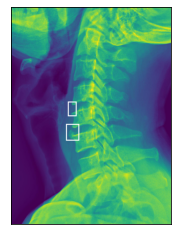

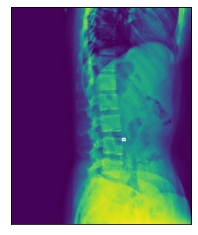

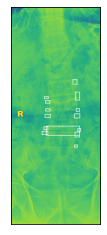

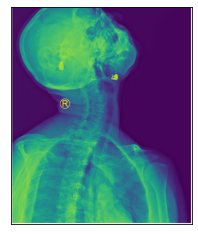

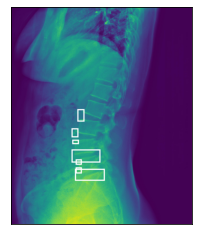

In [80]:
show_tranformed_image(train_loader,5)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_faster_rcnn_model(num_classes=8,trainable_backbone_layers=3).to(device)
optim = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
n_epochs = 1
best_model = SaveBestModel("model_object.pt",path)

In [82]:
model, train_history,valid_history, mAP_history = train_model(model, best_model, train_loader,valid_loader, optim, path=path,evaluate_map_every=1)

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1:
----------------------------------------------------------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 91.242379	 Train Loss Classifier: 2.171493	 Train Loss Box Reg: 0.455302	 Train Loss Objectness: 85.923153	 Train Loss RPN box: 2.692427 


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Total Loss: 5.008018	 Classifier Loss: 0.470352	 Box Reg Loss: 0.417328	 Objectness Loss: 3.681069	 RPN box Loss: 0.439270 
Best validation loss: 5.008018493652344


  0%|          | 0/2 [00:00<?, ?it/s]

Saved best model


100%|██████████| 2/2 [00:05<00:00,  2.65s/it]


{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.), 'map_per_class': tensor([0., 0., 0., 0., 0., 0.]), 'mar_100_per_class': tensor([0., 0., 0., 0., 0., 0.])}


In [86]:
results = evaluate_average_precision(model,test_loader)

100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.), 'map_per_class': tensor([0., 0., 0., 0., 0.]), 'mar_100_per_class': tensor([0., 0., 0., 0., 0.])}


In [87]:
results

{'map': tensor(0.),
 'map_50': tensor(0.),
 'map_75': tensor(0.),
 'map_small': tensor(0.),
 'map_medium': tensor(0.),
 'map_large': tensor(0.),
 'mar_1': tensor(0.),
 'mar_10': tensor(0.),
 'mar_100': tensor(0.),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.),
 'mar_large': tensor(0.),
 'map_per_class': tensor([0., 0., 0., 0., 0.]),
 'mar_100_per_class': tensor([0., 0., 0., 0., 0.])}

In [88]:
## Other code

# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# train_transforms = A.Compose([
#         A.Flip(0.5),
#         ToTensorV2(p=1.0),
#     ], bbox_params={
#         'format': 'pascal_voc',
#         'label_fields': ['labels']
#     })

# test_transforms = A.Compose([
#         A.Flip(0.5),
#         ToTensorV2(p=1.0),
#     ], bbox_params={
#         'format': 'pascal_voc',
#         'label_fields': ['labels']
#     })

# train_dataset.__getitem__(0)[0].shape
# image_height = []
# image_width = []
# for images, targets in tqdm(train_loader):
#     for image in images:
#         #print(image.shape)
#         image_height.append(image.shape[1])
#         image_width.append(image.shape[2])
# for images, targets in tqdm(valid_loader):
#     for image in images:
#         #print(image.shape)
#         image_height.append(image.shape[1])
#         image_width.append(image.shape[2])
# for images, targets in tqdm(test_loader):
#     for image in images:
#         #print(image.shape)
#         image_height.append(image.shape[1])
#         image_width.append(image.shape[2])
# df = pd.DataFrame({
#     'image_height':image_height,
#     'image_width':image_width
# })
# df['aspect_ratio'] = df.image_width/image_height